In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
cols_to_use = ['age',
                'job',
                'marital',
                'education',
                'balance',
                'housing',
                'contact',
                'day',
                'month',
                'duration',
                'campaign',
                'pdays',
                'previous',
                'poutcome',
                'y']

In [4]:
df = pd.read_csv("../data/bank-full.csv", sep=';')
df.shape

(45211, 17)

In [5]:
df = df[cols_to_use].copy()
df.shape

(45211, 15)

In [6]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


# Question 1

In [7]:
numerical = df.select_dtypes(include='number').columns.tolist()
categorical = [x for x in df.columns if x not in numerical and x!='y']
df['y'] = np.where(df['y']=='yes', 1, 0)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [14]:
rv = {}
question_vars = ['balance', 'day', 'duration', 'previous']
for var in numerical:
    score = roc_auc_score(y_train, df_train[var])
    if score < 0.5:
        prior_score = score
        feat = -df_train[var]
        score = roc_auc_score(y_train, feat)
        print(f"Inverted variable {var}: prior score {prior_score.round(2)}, updated score {score.round(2)}")
    if var in question_vars:
        rv[var] = score

Inverted variable age: prior score 0.49, updated score 0.51
Inverted variable day: prior score 0.47, updated score 0.53
Inverted variable campaign: prior score 0.43, updated score 0.57


In [15]:
rv

{'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'previous': 0.5985653242764153}

In [16]:
max(rv, key=rv.get)

'duration'

# Question 2

In [17]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [18]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [19]:
dv, model = train(df_train, y_train)

In [20]:
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
print(f"ROC AUC Score: {np.round(auc, 3)}")

ROC AUC Score: 0.9


# Question 3

In [21]:
def precision_recall_df(y_val, y_pred):
    scores = []
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    thresholds = np.arange(0, 1, 0.01) # step 0.01
    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()

        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()

        scores.append((t, tp, tn, fp, fn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
    df_scores['precision'] = df_scores.tp/ (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp/(df_scores.tp + df_scores.fn)
    df_scores['f1'] = 2 * (df_scores['precision']* df_scores['recall'])/(df_scores['precision'] + df_scores['recall'])
    return df_scores

In [22]:
df_scores = precision_recall_df(y_val, y_pred)

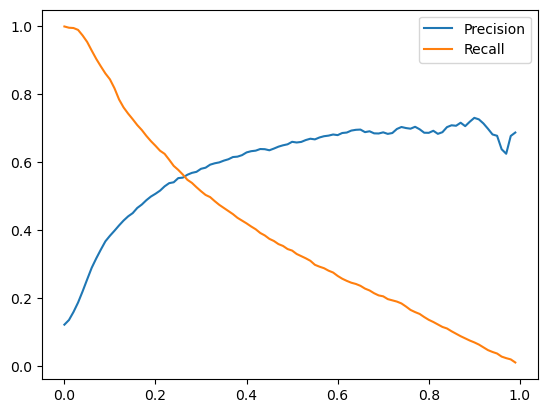

In [23]:
plt.plot(df_scores.threshold, df_scores['precision'],  label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()
plt.show()

In [24]:
df_scores['intersection'] = np.isclose(df_scores['precision'], df_scores['recall'], atol=0.01)

In [25]:
df_scores.query('intersection')

,threshold,tp,tn,fp,fn,precision,recall,f1,intersection
26,0.26,619,7447,497,479,0.554659,0.563752,0.559169,True


# Question 4

In [26]:
df_scores.iloc[df_scores['f1'].idxmax()]['threshold']

0.22

# Question 5

In [27]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [28]:
mean_score = np.mean(scores)
N = len(scores)
np.sqrt(1/(N-1) * np.sum([(x - mean_score)**2 for x in scores])).round(4)

0.0061

In [29]:
np.std(scores, ddof=1).round(4)

0.0061

# Question 6

In [30]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.005
